In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import pymaster as nmt
import scipy.linalg as LA
plt.rcParams['font.family'] = 'sans-serif'  

In [2]:
#import all
import sys
sys.path.append("../lib")
from tqdm import tqdm
import pysm_common as psm

import numpy as np
import healpy as hp
import pymaster as nmt 
import pysm3
import time
from mpfit import mpfit
import mpfitlib as mpl
import scipy
#from Nearest_Positive_Definite import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patheffects as path_effects
import scipy.stats as st
import basicfunc as func
import analys_lib as an
import simu_lib as sim
import pysm3.units as u

#sim params

r = 0
nside = 32
Npix = hp.nside2npix(nside)
N= 1
lmax = nside*2-1
#lmax=850
scale = 10
Nlbin = 10
fsky = 0.7
dusttype = 0
syncrotype = 0
kw = ''


# instr param

#ifreq=[0,9,10,21]
ifreq=np.arange(0,15)
instr_name='litebird_reduced'
instr =  np.load("../lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq= instr['frequencies']
#sens_P= instr['sens_P']
sens_P = np.array([37.42, 33.46, 21.31, 16.87, 12.07, 11.30, 6.56, 4.58, 4.79, 5.57, 5.85, 10.79, 13.80, 21.95, 47.45])
freq=freq[ifreq]
sens_P=sens_P[ifreq]
sigpix= sens_P/(np.sqrt((4*np.pi)/Npix*(60*180/np.pi)**2))
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()
N_freqs =len(freq)
Ncross=int(N_freqs*(N_freqs+1)/2)
fact_Dl= leff*(leff+1)/2/np.pi

nucross = []
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        nucross.append(np.sqrt(freq[i]*freq[j]))
nucross = np.array(nucross)

#cmb
CLcmb_or=hp.read_cl('../CLsimus/Cls_Planck2018_r0.fits') #TT EE BB TE
DL_lens = fact_Dl*b.bin_cell(CLcmb_or[2,:lmax+1])
DL_cross_lens = np.array([DL_lens for i in range(N_freqs) for j in range(i, N_freqs)])
#mask
if fsky==1:
    mask =  np.ones(Npix)
else:
    mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

#call foreground sky
if dusttype==None and syncrotype==None:
    mapfg=np.zeros((N_freqs,2,Npix))
else:
    if dusttype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['s%s'%syncrotype])#,'s%s'%synctype])
    if syncrotype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])#,'s%s'%synctype])
    if syncrotype!=None and dusttype!=None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype,'s%s'%syncrotype])
    mapfg= np.array([sim.downgrade_map(sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)),nside_in=512,nside_out=nside) for f in range(len(freq))])
    mapfg=mapfg[:,1:]


[login24:911785] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.login24.95058/jf.0/1925971968/shared_mem_cuda_pool.login24 could be created.
[login24:911785] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [3]:
# create N sims
noisemaps= np.zeros((N,3,N_freqs,2,Npix))
mapcmb = np.zeros((N,N_freqs,2,Npix))

for k in tqdm(range(0,N)):
    for p in range(3):
        for i in range(N_freqs):
            noisemaps[k,p,i,0] =np.random.normal(0,sigpix[i],size=Npix)
            noisemaps[k,p,i,1] =np.random.normal(0,sigpix[i],size=Npix)
    
    mapcmb0= hp.synfast(CLcmb_or,nside,pixwin=False,new=True)
    mapcmb1 = np.array([mapcmb0 for i in range(N_freqs)])
    mapcmb[k] = mapcmb1[:,1:]


100%|██████████| 1/1 [00:00<00:00, 28.27it/s]


In [4]:
#workspace
wsp_dc=[]
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        w_dc = nmt.NmtWorkspace()
        if i != j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask,1*mapfg[j],purify_e=False, purify_b=True), b)
        if i==j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapfg[j],purify_e=False, purify_b=True), b)
        wsp_dc.append(w_dc)
 
wsp_dc=np.array(wsp_dc)

def computecross(map_FM1,map_FM2,map_HM1,map_HM2):
    CLcross=np.zeros((Ncross,len(leff)))
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            if i != j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*map_FM1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*map_FM2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            if i==j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*map_HM1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*map_HM2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            z = z +1
    return fact_Dl*CLcross

DLcross_coadd= np.zeros((N,Ncross,len(leff)))

for k in tqdm(range(0,N)):
    #addition du bruit aux cartes
    map_FM =    mapfg +  noisemaps[k,0] + mapcmb[k]
    map_HM1 =   mapfg +  noisemaps[k,1]*np.sqrt(2) + mapcmb[k]
    map_HM2 =   mapfg +  noisemaps[k,2]*np.sqrt(2) + mapcmb[k] 
    DLcross_coadd[k]= computecross(map_FM,map_FM,map_HM1,map_HM2)

DLcross_fg = computecross(mapfg,mapfg,mapfg,mapfg)

100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


In [5]:
DL_cross_noise=np.ones((Ncross,len(leff)))
z=0
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        DL_cross_noise[z]= fact_Dl*4*np.pi*sigpix[i]*sigpix[j]/Npix*DL_cross_noise[z]
        z=z+1

In [6]:
from collections import Counter
def max_rep(arr):
    counts = Counter(arr)  
    return max(counts.values()) 
    
def cov_analytic(nu_i,nu_j,nu_k,nu_l,DLcross_fg=None,DL_cross_lens=None,DL_cross_noise=None,corrfog=True):
    """
    compute the analytical estimate of the covariance from the signal using Knox formula
    :param nu_i,nu_j,nu_k,nu_l: The quadruplet of frequencies (nu_i,nu_j),(nu_k,nu_l) for which the covariance should be computed in GHz.
    :param DLcross_fg: The foreground binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox-full)
    :param DL_cross_lens: The cmb binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox-full)
    :param DL_cross_noise: The noise binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox-full)
    :param corrfog: if true correct for the cosmic variance of the foregrounds.
    """
    A = np.argwhere(freq==nu_i)[0,0]
    B = np.argwhere(freq==nu_j)[0,0]
    C = np.argwhere(freq==nu_k)[0,0]
    D = np.argwhere(freq==nu_l)[0,0]
    Nunique = max_rep([A,B,C,D])
    poscrossAA= np.argwhere(nucross==np.sqrt(nu_i*nu_i))[0,0]
    poscrossBB= np.argwhere(nucross==np.sqrt(nu_j*nu_j))[0,0]
    poscrossAB= np.argwhere(nucross==np.sqrt(nu_i*nu_j))[0,0]
    poscrossCD= np.argwhere(nucross==np.sqrt(nu_k*nu_l))[0,0]
    poscrossAC= np.argwhere(nucross==np.sqrt(nu_i*nu_k))[0,0]
    poscrossBD= np.argwhere(nucross==np.sqrt(nu_j*nu_l))[0,0]
    poscrossAD= np.argwhere(nucross==np.sqrt(nu_i*nu_l))[0,0]
    poscrossBC= np.argwhere(nucross==np.sqrt(nu_j*nu_k))[0,0]

    v_l = (2*leff+1)*Nlbin*np.mean(mask**2)**2/np.mean(mask**4)
    
    if A ==C and B == D:
        if A==B:
            DLAB =  DL_cross_lens[poscrossAA] + DLcross_fg[poscrossAA]
            DLAA =  DL_cross_lens[poscrossAA] + 2*DL_cross_noise[poscrossAA] + DLcross_fg[poscrossAA] 
            DLBB =  DLAA
        else:
            DLAB = DLcross_fg[poscrossAB] + DL_cross_lens[poscrossAB]
            DLAA = DL_cross_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBB = DL_cross_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
        
        if corrfog==True:
            covmat = (DLAB**2+DLAA*DLBB - DLcross_fg[poscrossAB]**2 -DLcross_fg[poscrossAA]*DLcross_fg[poscrossBB])/v_l
        else:
            covmat = (DLAB**2+DLAA*DLBB)/v_l
   
    elif Nunique == 2 and A != B and C != D:
        if A==C:
            DLAA = DL_cross_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBD = DL_cross_lens[poscrossBD] + DLcross_fg[poscrossBD]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAD = DL_cross_lens[poscrossAD] + DLcross_fg[poscrossAD]
            if corrfog==True:
                covmat = (DLAA*DLBD+DLAB*DLAD - DLcross_fg[poscrossAA]*DLcross_fg[poscrossBD] -DLcross_fg[poscrossAB]*DLcross_fg[poscrossAD])/v_l
            else:
                covmat = (DLAA*DLBD+DLAB*DLAD)/v_l
        elif B==C:
            DLBB = DL_cross_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
            DLBD = DL_cross_lens[poscrossBD] + DLcross_fg[poscrossBD]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAD = DL_cross_lens[poscrossAD] + DLcross_fg[poscrossAD]
            if corrfog==True:
                covmat = (DLAB*DLBD+DLAD*DLBB - DLcross_fg[poscrossAB]*DLcross_fg[poscrossBD] -DLcross_fg[poscrossAD]*DLcross_fg[poscrossBB])/v_l
            else:
                covmat = (DLAB*DLBD+DLAD*DLBB)/v_l
        elif A==D:
            DLAA = DL_cross_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBC = DL_cross_lens[poscrossBC] + DLcross_fg[poscrossBC]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAC = DL_cross_lens[poscrossAC] + DLcross_fg[poscrossAC]
            if corrfog==True:
                covmat = (DLAA*DLBC+DLAB*DLAC - DLcross_fg[poscrossAA]*DLcross_fg[poscrossBC] -DLcross_fg[poscrossAB]*DLcross_fg[poscrossAC])/v_l
            else:
                covmat = (DLAA*DLBC+DLAB*DLAC)/v_l
        elif B==D:
            DLBB = DL_cross_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
            DLBC = DL_cross_lens[poscrossBC] + DLcross_fg[poscrossBC]
            DLAB = DL_cross_lens[poscrossAB] + DLcross_fg[poscrossAB]
            DLAC = DL_cross_lens[poscrossAC] + DLcross_fg[poscrossAC]
            if corrfog==True:
                covmat = (DLAB*DLBC+DLAC*DLBB - DLcross_fg[poscrossAB]*DLcross_fg[poscrossBC] -DLcross_fg[poscrossAC]*DLcross_fg[poscrossBB])/v_l
            else:
                covmat = (DLAB*DLBC+DLAC*DLBB)/v_l
            
    else:
        DLAC= DLcross_fg[poscrossAC] + DL_cross_lens[poscrossAC]
        DLBD= DLcross_fg[poscrossBD] + DL_cross_lens[poscrossBD]
        DLAD= DLcross_fg[poscrossAD] + DL_cross_lens[poscrossAD]
        DLBC= DLcross_fg[poscrossBC] + DL_cross_lens[poscrossBC]
        if corrfog==True:
            covmat = (DLAC*DLBD+DLAD*DLBC - DLcross_fg[poscrossAC]*DLcross_fg[poscrossBD] - DLcross_fg[poscrossAD]*DLcross_fg[poscrossBC])/v_l
        else: 
            covmat = (DLAC*DLBD+DLAD*DLBC)/v_l
    return covmat

In [7]:
def cov_analytic_signal(nu_i,nu_j,nu_k,nu_l,DL_signal=DLcross_coadd):
    """
    compute the analytical estimate of the covariance from the signal using Knox formula
    :param nu_i,nu_j,nu_k,nu_l: The quadruplet of frequencies (nu_i,nu_j),(nu_k,nu_l) for which the covariance should be computed in GHz.
    :param DL_signal: The signal binned DL array should be of the shape (Nsim, Ncross, Nell).
    """
    A = np.argwhere(freq==nu_i)[0,0]
    B = np.argwhere(freq==nu_j)[0,0]
    C = np.argwhere(freq==nu_k)[0,0]
    D = np.argwhere(freq==nu_l)[0,0]
    poscrossAC= np.argwhere(nucross==np.sqrt(nu_i*nu_k))[0,0]
    poscrossBD= np.argwhere(nucross==np.sqrt(nu_j*nu_l))[0,0]
    poscrossAD= np.argwhere(nucross==np.sqrt(nu_i*nu_l))[0,0]
    poscrossBC= np.argwhere(nucross==np.sqrt(nu_j*nu_k))[0,0]

    v_l = (2*leff+1)*Nlbin*np.mean(mask**2)**2/np.mean(mask**4)

    DLAC= DLcross_coadd[0,poscrossAC] 
    DLBD= DLcross_coadd[0,poscrossBD]
    DLAD= DLcross_coadd[0,poscrossAD]
    DLBC= DLcross_coadd[0,poscrossBC]
    
    covmat= (DLAC*DLBD+DLAD*DLBC)/v_l
    return covmat 

In [8]:
def getcov(DL,ellbin,N):
    return np.cov(np.swapaxes(DL[:N,:,ellbin],0,1))
cov_add=np.array([getcov(DLcross_coadd,l,N) for l in range(len(leff))])

/tmp/ipykernel_911785/664335579.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(np.swapaxes(DL[:N,:,ellbin],0,1))
/global/homes/l/leovchr/.conda/envs/myenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/global/homes/l/leovchr/.conda/envs/myenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


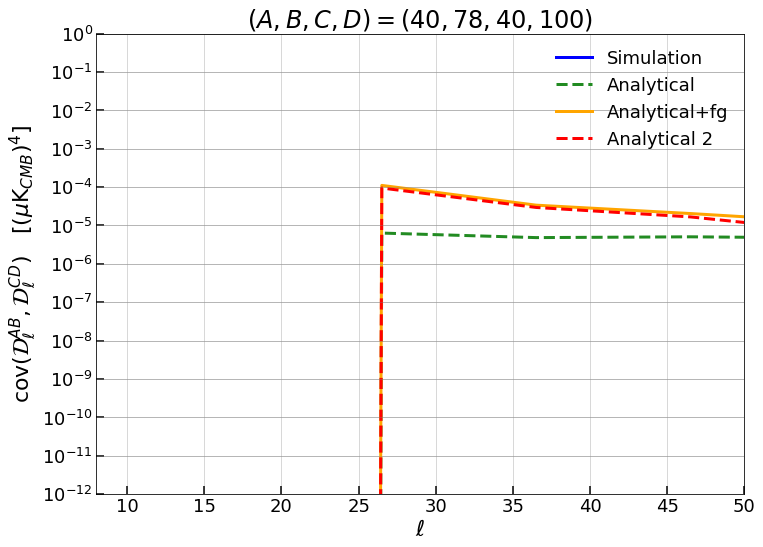

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

freq1, freq2, freq3, freq4 = 40, 78, 40, 100

plt.rcParams.update({
    'font.size': 20,  
    'axes.labelsize': 22,
    'axes.titlesize': 24,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

plt.figure(figsize=(11, 8)) 

poscrossAB = np.argwhere(nucross == np.sqrt(freq1 * freq2))[0, 0]
poscrossCD = np.argwhere(nucross == np.sqrt(freq3 * freq4))[0, 0]

plt.plot(leff, cov_add[:, poscrossAB, poscrossCD], label='Simulation', color='blue', linewidth=3)
plt.plot(leff, cov_analytic(freq1, freq2, freq3, freq4,DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise), label='Analytical', color='forestgreen', linestyle='--', linewidth=3)
plt.plot(leff, cov_analytic(freq1, freq2, freq3, freq4,DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,corrfog=False), label='Analytical+fg', color='orange', linestyle='-', linewidth=3)
plt.plot(leff, cov_analytic_signal(freq1, freq2, freq3, freq4,DL_signal=DLcross_coadd), label='Analytical 2', color='red', linestyle='--', linewidth=3)

plt.title(r'$(A,B,C,D)=(%d, %d, %d, %d)$' % (freq1, freq2, freq3, freq4))
plt.xlabel(r'$\ell$')
plt.ylabel(r'${\rm cov}(\mathcal{D}_\ell^{AB},\mathcal{D}_\ell^{CD}) \quad[(\mu {\rm K}_{CMB})^4]$')

ax = plt.gca()
ax.set_yscale('log')

yticks = 10.0 ** np.arange(-12, 1, 1)
ax.set_yticks(yticks)
for y in yticks:
    ax.axhline(y=y, color='gray', linestyle='-', linewidth=0.75, alpha=0.5)  
ax.grid(True, which='major', linestyle='-', linewidth=0.7, alpha=0.7)
ax.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.4)
ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.5)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1)
plt.xlim([8, 50])
#plt.ylim([1e-6, 100])
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.savefig('./%sx%s_%sx%s_leo.pdf' % (freq1, freq2, freq3, freq4), dpi=300)
plt.show()

In [10]:
def compute_analytical_cov(freq,DL_signal=None,DLcross_fg=None,DL_cross_lens=None,DL_cross_noise=None,type='signal',Linv=True):
    """
    compute an analytical estimate of the covariance matrix in different fashion.
    :param DL_signal: The signal binned DL array should be of the shape (Nsim, Ncross, Nell). Needed only to compute Knox formula from the signal (type=signal)
    :param DLcross_fg: The foreground binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox-full)
    :param DL_cross_lens: The cmb binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox-full)
    :param DL_cross_noise: The noise binned DL array should be of the shape (Ncross, Nell). Needed only to compute the analytical Knox formula (type=Knox-fg and type=Knox-full)
    :param type: type of estimate of the covariance. Can be "signal", "Knox-fg" or "Knox-full"
    :param Linv: If true return the Cholesky matrix computed from the inverse cov. If false return the covariance matrix. 
    """
    N, Ncross, Nell= DL_signal.shape
    covmat = np.zeros((Nell,Ncross,Ncross))
    doublets = {}
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            doublets[z]=(freq[i], freq[j])
            z=z+1
        
    for i in range(0,Ncross):
        for j in range(0,Ncross):
            nu_i,nu_j= doublets[i]
            nu_k,nu_l= doublets[j]
            if type=='signal':
                covmat[:,i,j]=cov_analytic_signal(nu_i,nu_j,nu_k,nu_l,DL_signal)
            if type=='Knox-full':
                covmat[:,i,j]= cov_analytic(nu_i,nu_j,nu_k,nu_l,DL_cross_lens=DL_cross_lens,DLcross_fg=DLcross_fg,DL_cross_noise=DL_cross_noise,corrfog=False)
            if type=='Knox-fg':
                covmat[:,i,j]= cov_analytic(nu_i,nu_j,nu_k,nu_l,DL_cross_lens=DL_cross_lens,DLcross_fg=DLcross_fg,DL_cross_noise=DL_cross_noise,corrfog=True)
    if Linv==True:
        invcov = np.array([np.linalg.inv(covmat[L]) for L in range(Nell)])
        Linv= np.array([np.linalg.cholesky(invcov[L]) for L in range(Nell)])
        return Linv
    else:
        return covmat

In [11]:
print(compute_analytical_cov(freq,DL_signal=DLcross_coadd,DLcross_fg=None,DL_cross_lens=None,DL_cross_noise=None,type='signal',Linv=False)[:,1,7])
print(cov_analytic_signal(40, 100, 119, 119))

[ 3.18851320e-02 -2.75816443e-05  4.72546274e-05  1.52945895e-05
  9.27945495e-06  4.06663913e-06]
[ 2.58162799e-02 -7.28352587e-06  2.66896236e-05  1.02278147e-05
  6.04095881e-06  3.13374959e-06]


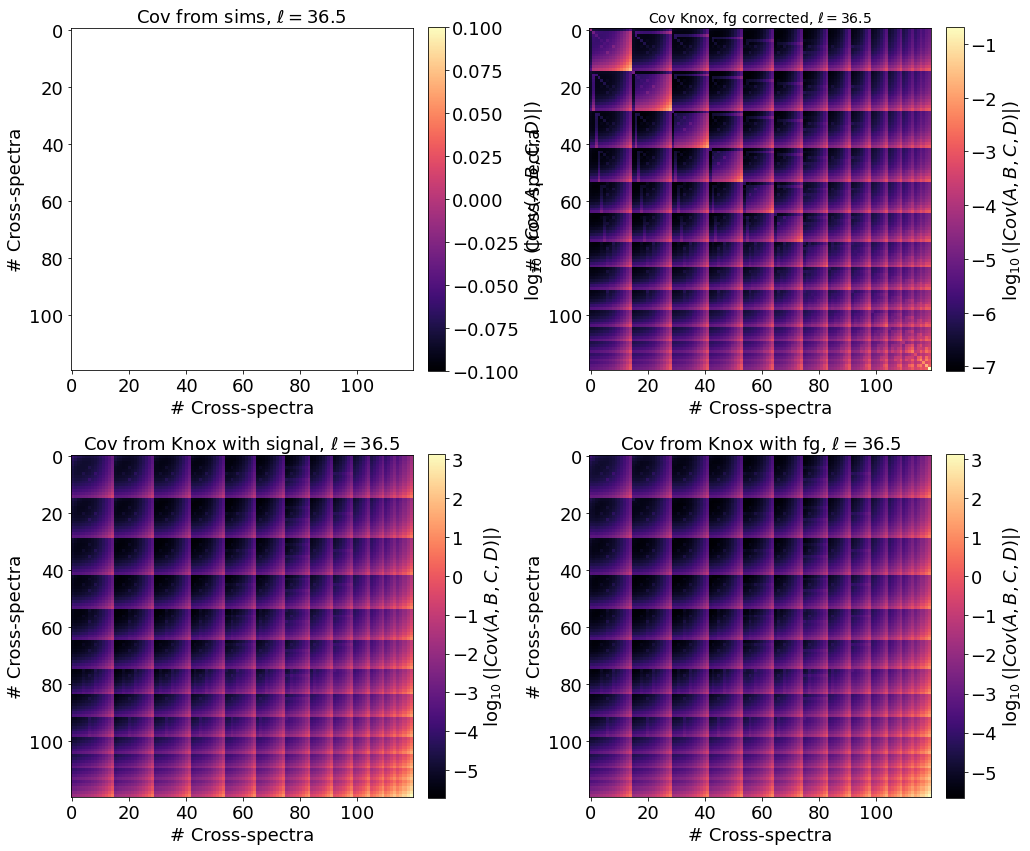

In [12]:
lbin = 3
cov_matrix_sims = np.log10(abs(cov_add[lbin]))
cov_matrix_knox = np.log10(abs(compute_analytical_cov(
    freq, DL_signal=DLcross_coadd, DLcross_fg=DLcross_fg, 
    DL_cross_lens=DL_cross_lens, DL_cross_noise=DL_cross_noise, 
    type='Knox-fg', Linv=False
)[lbin]))
cov_matrix_knox_fg = np.log10(abs(compute_analytical_cov(freq, DL_signal=DLcross_coadd, DLcross_fg=DLcross_fg, DL_cross_lens=DL_cross_lens, DL_cross_noise=DL_cross_noise, type='Knox-full', Linv=False)[lbin]))
cov_matrix_signal = np.log10(abs(compute_analytical_cov(freq,DL_signal=DLcross_coadd,DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='signal',Linv=False)[lbin]))

fig, axes = plt.subplots(2, 2, figsize=(14, 12)) 

im1 = axes[0,0].imshow(cov_matrix_sims, cmap='magma', aspect='equal', interpolation='nearest')
axes[0,0].set_xlabel("# Cross-spectra", fontsize=18)
axes[0,0].set_ylabel("# Cross-spectra", fontsize=18)
axes[0,0].set_title(r"Cov from sims, $\ell=%s$" % leff[lbin], fontsize=18)
fig.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04).set_label(r'$\log_{10}(|Cov(A,B,C,D)|)$', fontsize=18)

im2 = axes[0,1].imshow(cov_matrix_knox, cmap='magma', aspect='equal', interpolation='nearest')
axes[0,1].set_xlabel("# Cross-spectra", fontsize=18)
axes[0,1].set_ylabel("# Cross-spectra", fontsize=18)
axes[0,1].set_title(r"Cov Knox, fg corrected, $\ell=%s$" % leff[lbin], fontsize=14)
fig.colorbar(im2, ax=axes[0,1], fraction=0.046, pad=0.04).set_label(r'$\log_{10}(|Cov(A,B,C,D)|)$', fontsize=18)

im1 = axes[1,0].imshow(cov_matrix_signal, cmap='magma', aspect='equal', interpolation='nearest')
axes[1,0].set_xlabel("# Cross-spectra", fontsize=18)
axes[1,0].set_ylabel("# Cross-spectra", fontsize=18)
axes[1,0].set_title(r"Cov from Knox with signal, $\ell=%s$" % leff[lbin], fontsize=18)
fig.colorbar(im1, ax=axes[1,0], fraction=0.046, pad=0.04).set_label(r'$\log_{10}(|Cov(A,B,C,D)|)$', fontsize=18)

im2 = axes[1,1].imshow(cov_matrix_knox_fg, cmap='magma', aspect='equal', interpolation='nearest')
axes[1,1].set_xlabel("# Cross-spectra", fontsize=18)
axes[1,1].set_ylabel("# Cross-spectra", fontsize=18)
axes[1,1].set_title(r"Cov from Knox with fg, $\ell=%s$" % leff[lbin], fontsize=18)
fig.colorbar(im2, ax=axes[1,1], fraction=0.046, pad=0.04).set_label(r'$\log_{10}(|Cov(A,B,C,D)|)$', fontsize=18)
plt.tight_layout()  
plt.savefig("fullcov_fsky%s_leo.pdf"%fsky)

plt.show()


In [20]:
#invertible?
cov_matrix_knox = compute_analytical_cov(freq, DL_signal=DLcross_coadd, DLcross_fg=DLcross_fg, DL_cross_lens=DL_cross_lens, DL_cross_noise=DL_cross_noise, type='Knox-fg', Linv=False)

for l in range(15):
    print(l)
    invmat =np.linalg.inv(cov_matrix_knox[l])
    chol = np.linalg.cholesky(invmat)


0


LinAlgError: Matrix is not positive definite

In [17]:
#invertible?

cov_matrix_knox_fg = compute_analytical_cov(freq, DL_signal=DLcross_coadd, DLcross_fg=DLcross_fg, DL_cross_lens=DL_cross_lens, DL_cross_noise=DL_cross_noise, type='Knox-full', Linv=False)

for l in range(15):
    invmat =np.linalg.inv(cov_matrix_knox_fg[l])
    chol = np.linalg.cholesky(invmat)
    print(l)


LinAlgError: Matrix is not positive definite

In [21]:
#invertible?
cov_matrix_signal = compute_analytical_cov(freq,DL_signal=DLcross_coadd,DLcross_fg=DLcross_fg,DL_cross_lens=DL_cross_lens,DL_cross_noise=DL_cross_noise,type='signal',Linv=False)

for l in range(15):
    invmat =np.linalg.inv(cov_matrix_signal[l])
    chol = np.linalg.cholesky(invmat)
    print(l)


LinAlgError: Matrix is not positive definite

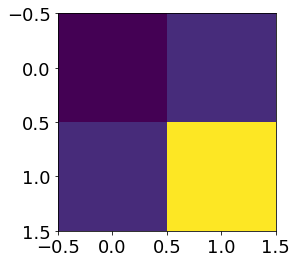

In [28]:
plt.imshow(np.log10(abs(cov_matrix_knox[3][3:5,5:7])))


In [31]:
cov_matrix_knox[3][4,6]

4.828124745671267e-06

In [35]:
doublets = {}
z=0

for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            doublets[z]=(freq[i], freq[j])
            z=z+1
        

In [36]:
doublets[4]

(40.0, 78.0)

In [37]:
doublets[6]

(40.0, 100.0)